<div style="font-size:2em; text-align:center; margin-top:30px; margin-bottom:20px">Smart Cities Project</div>
<hr>
<br>

<div style="font-size:4em; text-align:center; margin-bottom:30px; color:#00746E"><b>House Prediction Forecast</b></div>

In [1]:
# Load libraries
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns  # data visualisation
import matplotlib.pyplot as plt  # data visualisation
%matplotlib inline
import datetime as dt  # working with time data
import plotly.graph_objs as go  # plotly graphical object
import plotly.express as px
from pylab import rcParams
rcParams['figure.figsize'] = 15, 12
import statsmodels.api as sm  # time-series analysis for python
from statsmodels.tsa.stattools import adfuller  # Augmented Dickey-Fuller Test (ADF Test) to check for stationarity
from statsmodels.tsa.api import VAR  # # Fitting the VAR model to the 2nd Differenced Data
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tools.eval_measures import rmse, aic
import warnings  
warnings.filterwarnings('ignore')
import missingno as msno
# from fbprophet import Prophet
# import geopandas as gpd
from sklearn.metrics import mean_squared_error  # MSE
from numpy import asarray as arr

# Allows to display all of the outputs of a cell
from IPython.display import display

# Set float data type format
pd.options.display.float_format = '{:,.2f}'.format

# Set the maximum number of row to be displayed
pd.options.display.max_rows = 999

# Set global visualisation settings
plt.rc('font', size=14)

In [2]:
# Load dataset
file_name = "./Smart_Cities/data/housing_in_london_monthly_variables.csv"
df = pd.read_csv(file_name, parse_dates = ['date'])
# df[:10]
print ('This dataset contains {} rows and {} columns.'.format(df.shape[0], df.shape[1]))
df.head()

This dataset contains 13549 rows and 7 columns.


date            area  average_price       code  houses_sold  \
0 1995-01-01  city of london          91449  E09000001        17.00   
1 1995-02-01  city of london          82203  E09000001         7.00   
2 1995-03-01  city of london          79121  E09000001        14.00   
3 1995-04-01  city of london          77101  E09000001         7.00   
4 1995-05-01  city of london          84409  E09000001        10.00   

   no_of_crimes  borough_flag  
0           nan             1  
1           nan             1  
2           nan             1  
3           nan             1  
4           nan             1

# Data Preprocess

average_price  houses_sold  no_of_crimes  borough_flag
count      13,549.00    13,455.00      7,439.00     13,549.00
mean      263,519.68     3,893.99      2,158.35          0.73
std       187,617.50    12,114.40        902.09          0.44
min        40,722.00         2.00          0.00          0.00
25%       132,380.00       247.00      1,623.00          0.00
50%       222,919.00       371.00      2,132.00          1.00
75%       336,843.00     3,146.00      2,582.00          1.00
max     1,463,378.00   132,163.00      7,461.00          1.00

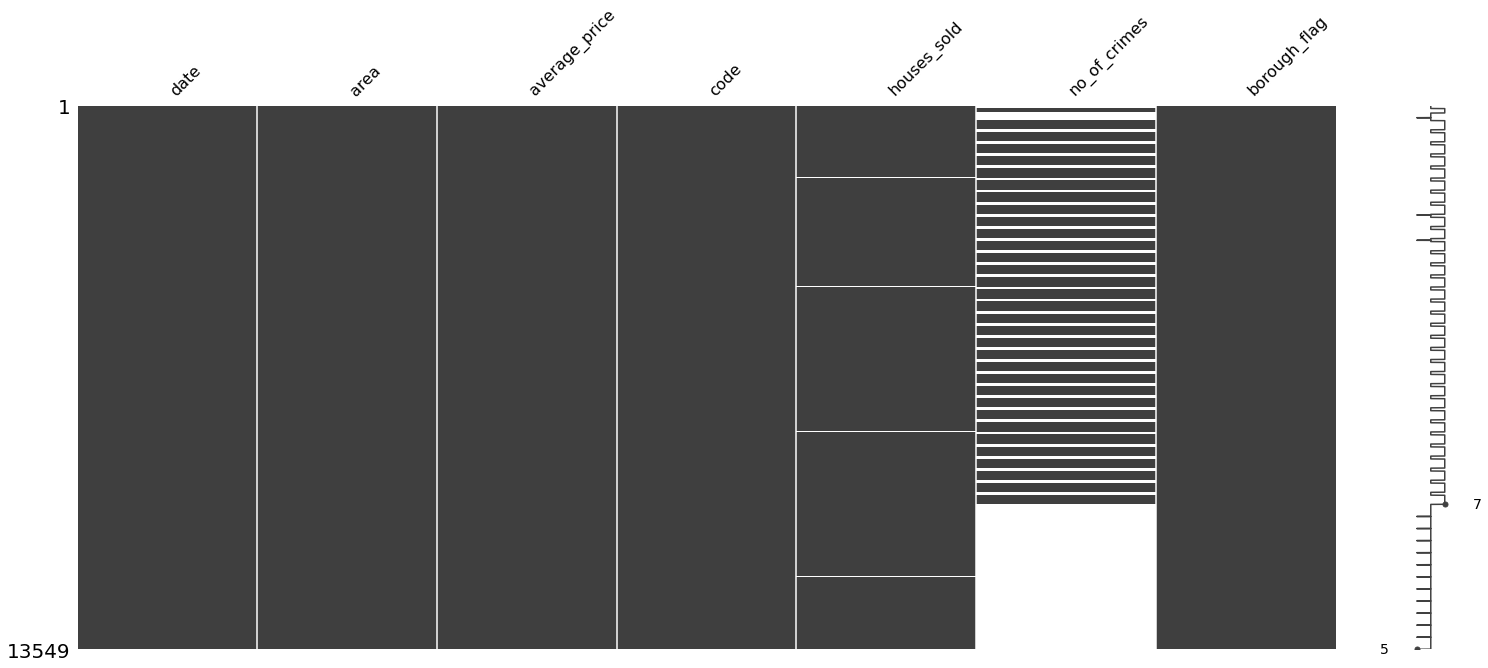

In [3]:
display(df.describe());

msno.matrix(df);

Observations:
* Yearly data is missing a few **'houses_sold'** values 
* Many values are missing for the **'no_of_crimes'** variable

In [4]:
# Set date as index for easier manipulation
df = df.set_index(pd.to_datetime(df['date']))

del df['date']

# Create dataset cuts
prices_london = df[df['borough_flag'] == 1]
prices_england = df[df['area'] == 'england']
prices_north_east = df[df['area'] == 'north east']

# Calculate mean prices for the different cuts of data
london_mean_price = prices_london.groupby('date')['average_price'].mean()
england_mean_price = prices_england.groupby('date')['average_price'].mean()
north_east_mean_price = prices_north_east.groupby('date')['average_price'].mean()

print('Processing Complete')

Processing Complete


# Data Exploration

In [5]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=london_mean_price.index, 
                         y=london_mean_price.values,
                         mode='lines',
                         name='London Mean House Price',
                        ))

fig.add_trace(go.Scatter(x=england_mean_price.index, 
                         y=england_mean_price.values,
                         mode='lines',
                         name='England Mean House Price',
                        ))

fig.add_trace(go.Scatter(x=north_east_mean_price.index, 
                         y=north_east_mean_price.values,
                         mode='lines',
                         name='North East Mean House Price',
                        ))


fig.update_layout(
    template='gridon',
    title='Average Monthly House Price',
    xaxis_title='Year',
    yaxis_title='Price (£)',
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    legend=dict(y=-.2, orientation='h'),
    shapes=[
        dict(
            type="line",
            x0='2016-06-01',
            x1='2016-06-01',
            y0=0,
            y1=london_mean_price.values.max()*1.2,
            line=dict(
            color="LightSalmon",
            dash="dashdot"
            )
        ),
        dict(
            type="rect",
            x0="2007-12-01",
            y0=0,
            x1="2009-06-01",
            y1=london_mean_price.values.max()*1.2,
            fillcolor="LightSalmon",
            opacity=0.5,
            layer="below",
            line_width=0,
        ),
        dict(
            type="rect",
            x0="2001-03-01",
            y0=0,
            x1="2001-11-01",
            y1=london_mean_price.values.max()*1.2,
            fillcolor="LightSalmon",
            opacity=0.5,
            layer="below",
            line_width=0,
        )
    ],
    annotations=[
            dict(text="The Great Recession", x='2007-12-01', y=london_mean_price.values.max()*1.2),
            dict(text="Brexit Vote", x='2016-06-01', y=london_mean_price.values.max()*1.2),
            dict(text="Dot-Com Bubble Recession", x='2001-03-01', y=london_mean_price.values.max()*1.2)
    ]
)

fig.show()

London's house prices are well above average when compared to England's. Furthermore, it dwarfs the prices of the relatively poor North East region.

It is clear that the global recession in 2008 has made a radical adjustment to the overall house prices, however, this was only temporary and London's house prices have rebounded since. The Brexit vote in 2016 has not impacted the prices in a significant way, but the price growth has plateaued.

As expected, the recession that followed the dot-com bubble had no material impact on UK's house prices. This is because this particular recession was mostly concentrated in the USA.

In [6]:
fig = px.line(prices_london, x=prices_london.index, y="average_price", color='area')

fig.update_layout(
    template='gridon',
    title='Average Monthly London House Price by Borough',
    xaxis_title='Year',
    yaxis_title='Price (£)',
    xaxis_showgrid=False,
    yaxis_showgrid=False
)

fig.show()

London has 33 boroughs (including City of London). Visually, this makes the exploration of the graph difficult. Luckily, Plotly allows to dynamically explore the data. You can click on area to hide it or double click to hide all other areas. Some key observations:
* Kensington and Chelsea historically has been and remains the most expensive borough to buy a house in
* The more expensive boroughs have greater volatility in average price
* Brent had a significant decline in house prices since 2019

In [7]:
# Calculate the mean yearly price per borough
yearly_prices_london = prices_london.groupby('area').resample('y')['average_price'].mean()

# Calculate the yealy average price percentage change
yearly_prices_london_pct_ch = yearly_prices_london.groupby(level='area').apply(lambda x: x.pct_change())

yearly_prices_london_pct_ch = yearly_prices_london_pct_ch.unstack()
yearly_prices_london_pct_ch = yearly_prices_london_pct_ch.iloc[::-1]

del yearly_prices_london_pct_ch['1995-12-31']

In [8]:
fig = go.Figure(data=go.Heatmap(
        z=yearly_prices_london_pct_ch.values,
        x=yearly_prices_london_pct_ch.columns,
        y=yearly_prices_london_pct_ch.index,
        colorscale='Cividis'))

fig.update_layout(
    title='YoY Average London House Price Percentage Change',
    title_x=0.5,
    yaxis_nticks=33,
    xaxis_title='Year',
    yaxis_title='Borough'
)

fig.show()

A heatmap provides an interesting way to analyze the changes in house prices. The year 2000 has seen the sharpest house price rise. The mid '10 have also seen the prices trending upwards, but they have been relatively stable / decreasing since. 

In [12]:
# # Load the shape file for mapping
# map_df = gpd.read_file('../input/london-borough-and-ward-boundaries-up-to-2014/London_Wards/Boroughs/London_Borough_Excluding_MHW.shp')

# map_df = map_df[['NAME', 'geometry']]
# map_df = map_df.rename(columns={'NAME': 'area'})
# map_df['area'] = map_df['area'].str.lower()
# map_df['area'] = map_df['area'].str.replace('&','and')

# yearly_prices_london_df_map = pd.DataFrame(yearly_prices_london)
# yearly_prices_london_df_map = yearly_prices_london_df_map.reset_index()

# price_map = map_df.set_index('area').join(yearly_prices_london_df_map.set_index('area'))
# price_map = price_map.reset_index()

# price_map = price_map[price_map['date'] == '2019-12-31']

In [14]:
# variable = 'average_price'

# fig, ax = plt.subplots(1, figsize=(15, 10))
# price_map.plot(column=variable, 
#                cmap='Blues', 
#                linewidth=1, 
#                ax=ax, 
#                edgecolor='0.8', 
#                legend=True,
#                legend_kwds={'label': "Average House Price",
#                            'orientation': "horizontal"})
# ax.axis('off')
# plt.suptitle('Average London House Price by Borough Visualised')
# plt.show()

The map nicely illustrates that West London tends to be a much more expensive place to live than East London. 

---------------------------------------------------------------------------------------------------------------------------

In [25]:
df.head(5)

average_price  houses_sold  no_of_crimes
date                                                
1995-01-01          91449        17.00           nan
1995-02-01          82203         7.00           nan
1995-03-01          79121        14.00           nan
1995-04-01          77101         7.00           nan
1995-05-01          84409        10.00           nan

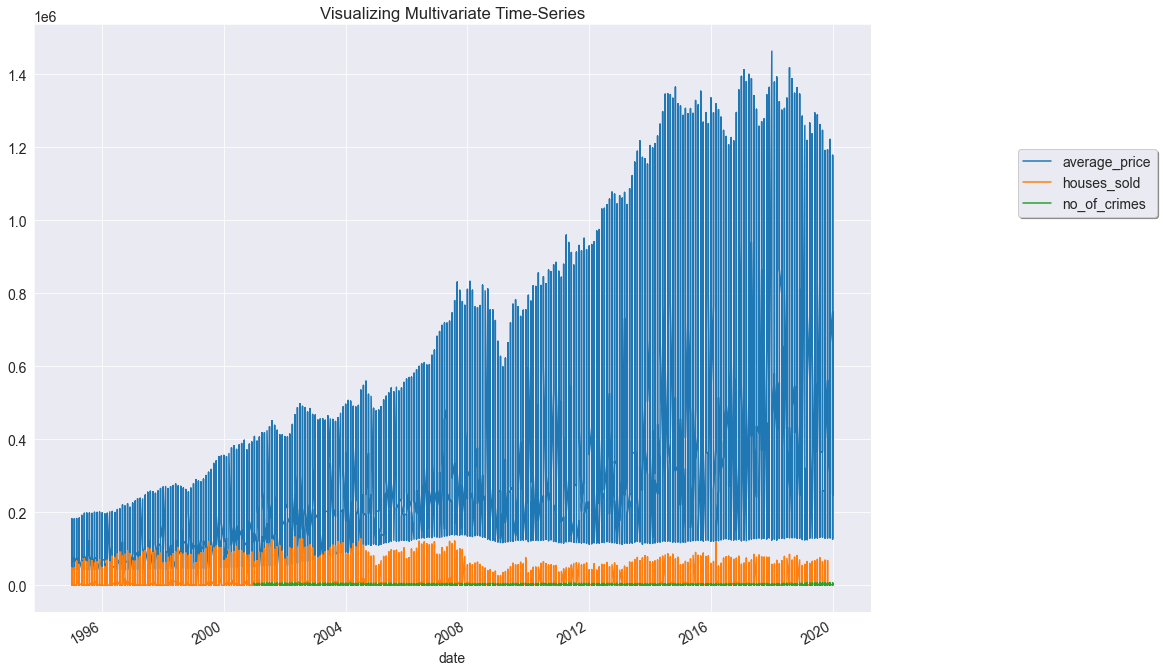

In [26]:


# Visualize the trends in data
# sns.set_style('darkgrid')
# df.plot(kind = 'line', legend = 'reverse', title = 'Visualizing Multivariate Time-Series')
# plt.legend(loc = 'upper right', shadow = True, bbox_to_anchor = (1.35, 0.8))
# plt.show()

# Dropping area, code, & borough flag as they do not change with Time
# df_time_series = df.drop(['area', 'code', 'borough_flag'], axis = 1)  # inplace = True

# Again Visualizing the time-series data
sns.set_style('darkgrid')
df.plot(kind = 'line', legend = 'reverse', title = 'Visualizing Multivariate Time-Series')
# df_time_series.plot(kind = 'line', legend = 'reverse', title = 'Visualizing Multivariate Time-Series')
plt.legend(loc = 'upper right', shadow = True, bbox_to_anchor = (1.35, 0.8))
plt.show()

In [32]:
df['no_of_crimes'] = df['no_of_crimes'].fillna(0)
df['houses_sold'] = df['houses_sold'].fillna(0)

In [33]:
# Splitting the dataset into train & test subsets
n_obs = 100
df_train, df_test = df[:-n_obs], df[-n_obs:]

def adf_test(df):
    dftest = adfuller(df, autolag='AIC')
    adf = pd.Series(dftest[0:4], index = ['Test Statistic','p-value','# Lags','# Observations'])

    for key, value in dftest[4].items():
       adf['Critical Value (%s)'%key] = value
    print (adf)

    p = adf['p-value']
    if p <= 0.05:
        print("\nSeries is Stationary")
    else:
        print("\nSeries is Non-Stationary")


for i in df_train.columns:
    print("Column: ",i)
    print('--------------------------------------')
    adf_test(df_train[i])
    print('\n')

# Differencing all variables to get rid of Stationarity
df_differenced = df_train.diff().dropna()

# Running the ADF test once again to test for Stationarity
for i in df_differenced.columns:
    print("Column: ",i)
    print('--------------------------------------')
    adf_test(df_differenced[i])
    print('\n')

# Now cols: 3, 5, 6, 8 are non-stationary
df_differenced = df_differenced.diff().dropna()

# Running the ADF test for the 3rd time to test for Stationarity
for i in df_differenced.columns:
    print("Column: ",i)
    print('--------------------------------------')
    adf_test(df_differenced[i])
    print('\n')

Column:  average_price
--------------------------------------
Test Statistic             -8.97
p-value                     0.00
# Lags                     13.00
# Observations         13,435.00
Critical Value (1%)        -3.43
Critical Value (5%)        -2.86
Critical Value (10%)       -2.57
dtype: float64

Series is Stationary


Column:  houses_sold
--------------------------------------
Test Statistic             -2.82
p-value                     0.06
# Lags                     41.00
# Observations         13,407.00
Critical Value (1%)        -3.43
Critical Value (5%)        -2.86
Critical Value (10%)       -2.57
dtype: float64

Series is Non-Stationary


Column:  no_of_crimes
--------------------------------------
Test Statistic             -8.90
p-value                     0.00
# Lags                     41.00
# Observations         13,407.00
Critical Value (1%)        -3.43
Critical Value (5%)        -2.86
Critical Value (10%)       -2.57
dtype: float64

Series is Stationary


Col

---------------------------------------------------------------------------------------------------------------------------

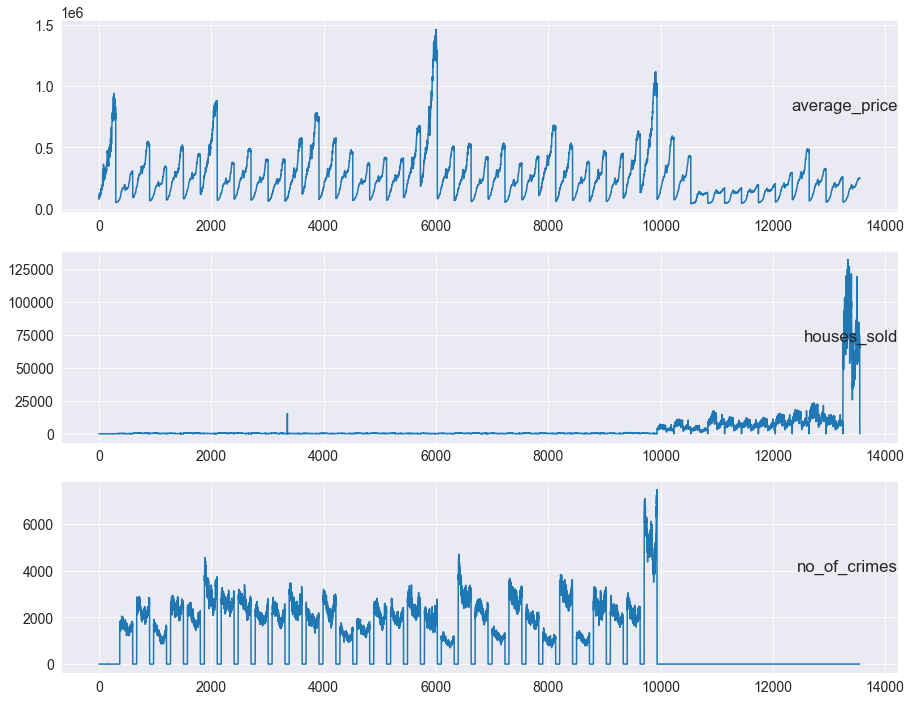

In [46]:
values = df.values
# specify columns to plot
groups = [0, 1, 2]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

---------------------------------------------------------------------------------------------------------------------------

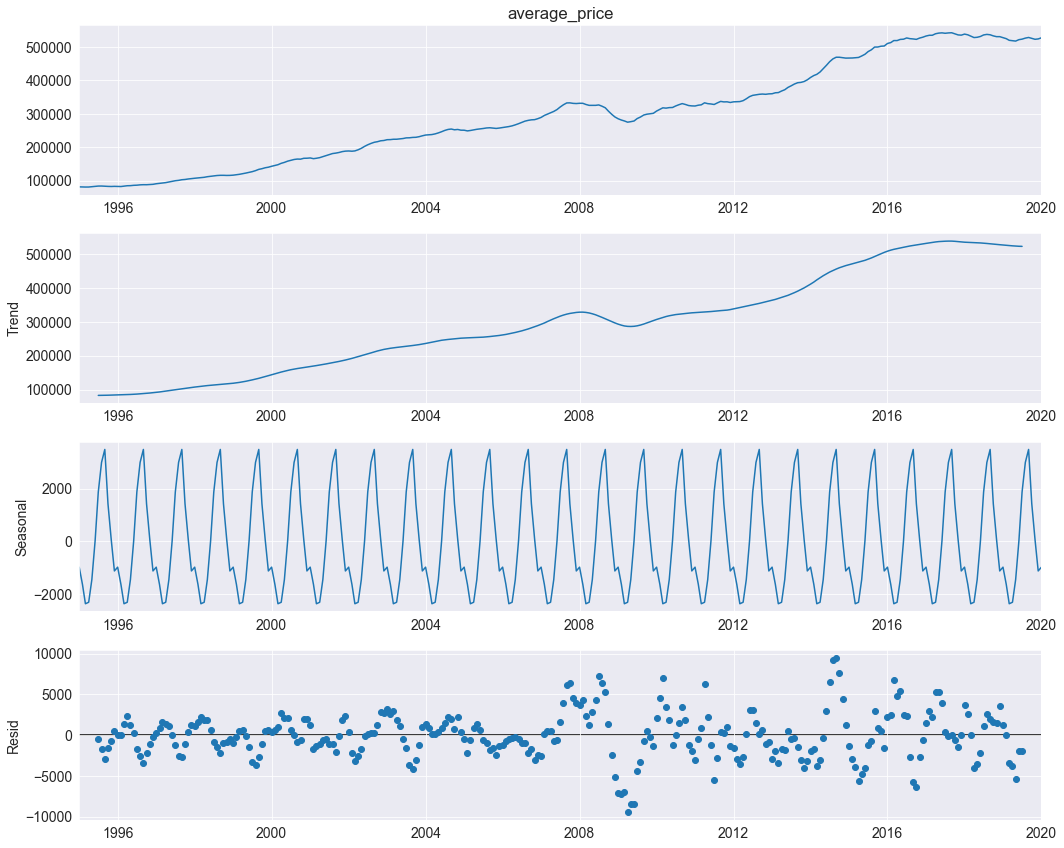

In [39]:
decomposition = sm.tsa.seasonal_decompose(london_mean_price, model='additive')
fig = decomposition.plot()
plt.show()

-------------------------------------------------------------------------------------------------------------------------------

In [51]:
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [53]:
df.head()

average_price  houses_sold  no_of_crimes
date                                                
1995-01-01          91449        17.00          0.00
1995-02-01          82203         7.00          0.00
1995-03-01          79121        14.00          0.00
1995-04-01          77101         7.00          0.00
1995-05-01          84409        10.00          0.00

In [65]:
df.shape

(13549, 3)

In [69]:
duplicate = df[df.duplicated('average_price')]
duplicate.shape

(206, 3)

In [74]:
# dropping ALL duplicate values
df.drop_duplicates(subset ="average_price", keep = False, inplace = True)

In [75]:
df.shape

(13143, 3)

In [76]:
# Converting the time series data to long table format
wide_df = df.pivot(columns = 'average_price')
wide_df = wide_df.reset_index(level = ['date'])
wide_df

date houses_sold                                      \
average_price                  40722    40790    41588    41688    41728   
0             1995-01-01         nan      nan      nan      nan      nan   
1             1995-02-01         nan      nan      nan      nan      nan   
2             1995-03-01         nan      nan      nan      nan      nan   
3             1995-04-01         nan      nan      nan      nan      nan   
4             1995-05-01         nan      nan      nan      nan      nan   
5             1995-06-01         nan      nan      nan      nan      nan   
6             1995-07-01         nan      nan      nan      nan      nan   
7             1995-08-01         nan      nan      nan      nan      nan   
8             1995-09-01         nan      nan      nan      nan      nan   
9             1995-10-01         nan      nan      nan 2,674.00      nan   
10            1995-11-01         nan      nan      nan      nan 2,620.00   
11            1995-12-01         nan      nan      nan      nan      nan   
12            1996-01-01         nan 2,020.00      nan      nan      nan   
13            1996-02-01    2,113.00      nan      nan      nan      nan   
14            1996-03-01         nan      nan      nan      nan      nan   
15            1996-04-01         nan      nan 2,604.00      nan      nan   
16            1996-05-01         nan      nan      nan      nan      nan   
17            1996-06-01         nan      nan      nan      nan      nan   
18            1996-07-01         nan      nan      nan      nan      nan   
19            1996-08-01         nan      nan      nan      nan      nan   
20            1996-09-01         nan      nan      nan      nan      nan   
21            1996-10-01         nan      nan      nan      nan      nan   
22            1996-11-01         nan      nan      nan      nan      nan   
23            1996-12-01         nan      nan      nan      nan      nan   
24            1997-01-01         nan      nan      nan      nan      nan   
25            1997-02-01         nan      nan      nan      nan      nan   
26            1997-03-01         nan      nan      nan      nan      nan   
27            1997-04-01         nan      nan      nan      nan      nan   
28            1997-05-01         nan      nan      nan      nan      nan   
29            1997-06-01         nan      nan      nan      nan      nan   
30            1997-07-01         nan      nan      nan      nan      nan   
31            1997-08-01         nan      nan      nan      nan      nan   
32            1997-09-01         nan      nan      nan      nan      nan   
33            1997-10-01         nan      nan      nan      nan      nan   
34            1997-11-01         nan      nan      nan      nan      nan   
35            1997-12-01         nan      nan      nan      nan      nan   
36            1998-01-01         nan      nan      nan      nan      nan   
37            1998-02-01         nan      nan      nan      nan      nan   
38            1998-03-01         nan      nan      nan      nan      nan   
39            1998-04-01         nan      nan      nan      nan      nan   
40            1998-05-01         nan      nan      nan      nan      nan   
41            1998-06-01         nan      nan      nan      nan      nan   
42            1998-07-01         nan      nan      nan      nan      nan   
43            1998-08-01         nan      nan      nan      nan      nan   
44            1998-09-01         nan      nan      nan      nan      nan   
45            1998-10-01         nan      nan      nan      nan      nan   
46            1998-11-01         nan      nan      nan      nan      nan   
47            1998-12-01         nan      nan      nan      nan      nan   
48            1999-01-01         nan      nan      nan      nan      nan   
49            1999-02-01         nan      nan      nan      nan      nan   
50            1999-03-01         nan      nan      nan      nan     

In [92]:
# wide_df.columns = wide_df.columns.droplevel(0)
# wide_df
# wide_df.columns = ['date', 'average_price', 'houses_sold', 'no_of_crimes']
# wide_df.set_index('date', inplace = True)

In [58]:
# grangers_causation_matrix(wide_df, variables = wide_df.columns) 

If a given p-value is < significance level (0.05), then, the corresponding X series (column) causes the Y (row). In this case, the null hypothesis is significant (0.0), therefore we reject null hypothesis, and say that `sales of item1` causes `sales of item2`.
    
This makes this system of multi time series a good candidate for using VAR models to forecast.

Next, let’s do the Cointegration test.

In [60]:
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [93]:
# cointegration_test(wide_df)

In [83]:
nobs = 30
df_train, df_test = wide_df[0:-nobs], wide_df[-nobs:]

# Check size
print(df_train.shape)  # (1796, 2)
print(df_test.shape)  # (30, 2)

(271, 26287)
(30, 26287)


In [84]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [86]:
df['no_of_crimes'] = df['no_of_crimes'].fillna(0)
df['houses_sold'] = df['houses_sold'].fillna(0)

In [88]:
df.head()

average_price  houses_sold  no_of_crimes
date                                                
1995-01-01          91449        17.00          0.00
1995-02-01          82203         7.00          0.00
1995-03-01          79121        14.00          0.00
1995-04-01          77101         7.00          0.00
1995-05-01          84409        10.00          0.00

In [94]:
# # ADF Test on each column
# for name, column in df_train.iteritems():
#     adfuller_test(column, name=column.name)
#     print('\n')

In [89]:
# Perform 1st order differencing 
df_differenced = df_train.diff().dropna()

In [95]:
# # ADF Test on each column of 1st Differences Dataframe
# for name, column in df_differenced.iteritems():
#     adfuller_test(column, name=column.name)
#     print('\n')

In [96]:
# model = VAR(df_differenced)
# for i in list(range(1, 9)):
#     result = model.fit(i)
#     print('Lag Order =', i)
#     print('AIC : ', result.aic)
#     print('BIC : ', result.bic)
#     print('FPE : ', result.fpe)
#     print('HQIC: ', result.hqic, '\n')

In [101]:
# x = model.select_order(maxlags=12)
# x.summary()

In [102]:
# model_fitted = model.fit(4)
# model_fitted.summary()

In [103]:
# from statsmodels.stats.stattools import durbin_watson
# out = durbin_watson(model_fitted.resid)

# for col, val in zip(buf.columns, out):
#     print(col, ':', round(val, 2))

In [98]:
# # Get the lag order
# lag_order = model_fitted.k_ar
# print(lag_order)  #> 4

In [97]:
# # Input data for forecasting
# forecast_input = df_differenced.values[-lag_order:]
# forecast_input

In [100]:
# # Forecast
# fc = model_fitted.forecast(y=forecast_input, steps=nobs)
# df_forecast = pd.DataFrame(fc, index=wide_df.index[-nobs:], columns=wide_df.columns + '_1d')
# df_forecast

In [99]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [104]:
# df_results = invert_transformation(df_train, df_forecast, second_diff=False)   
# df_results.loc[:, ['item1_forecast', 'item2_forecast']    ].round(2)

In [105]:
# df_results_f = df_results.loc[:, ['item1_forecast', 'item2_forecast']    ].round(2)
# df_results_f.set_index(df_test.index, inplace = True) 
# df_results_f.reset_index(inplace = True)
# df_results_f

In [106]:
# # Visualise time series
# df_results_long = pd.melt(df_results_f, id_vars = ["date"], value_vars = ['item1_forecast', 'item2_forecast'], var_name = 'item', value_name ='sales')
# df_results_long['item'] = df_results_long['item'].str.replace('_forecast', '')


In [107]:
# df_results_long.head()

In [108]:
# df_results_long['date'] = df_results_long.date.dt.strftime('%Y-%m-%d')

In [109]:
# import plotly.express as px
# fff = px.line(df_results_long, x = 'date', y = 'sales', color = 'item' )
# fff.update_layout(title = 'Forecasted sales for Item 1 and Item 2')
# fff.show()

# House Price Prediction

In [19]:
# # Prepare the 
# model_df = pd.DataFrame(london_mean_price).reset_index()
# model_df = model_df.rename(columns={'date': 'ds', 'average_price': 'y'})

# # Initialise the model and make predictions
# m = Prophet()
# m.fit(model_df)

# future = m.make_future_dataframe(periods=24, freq='M')

# forecast = m.predict(future)

# # Visualise the prediction
# fig1 = m.plot(forecast)

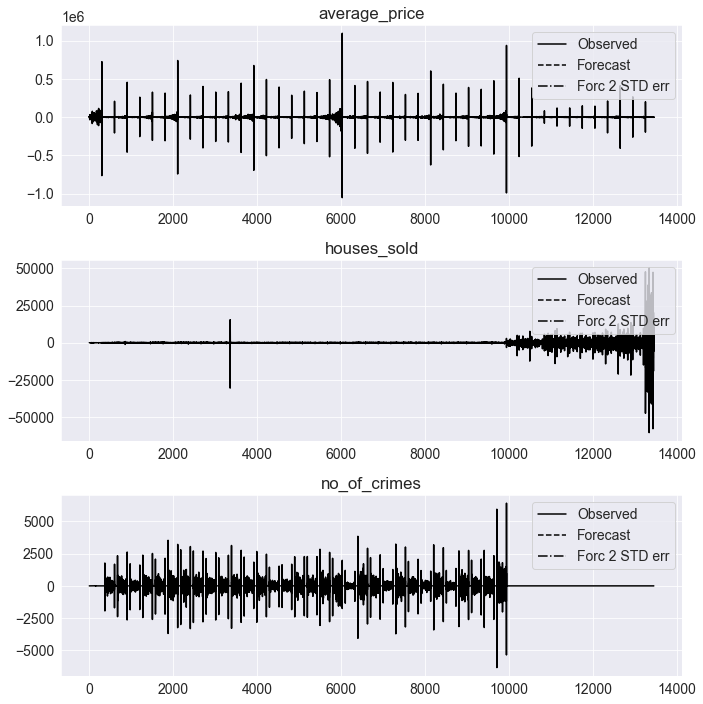

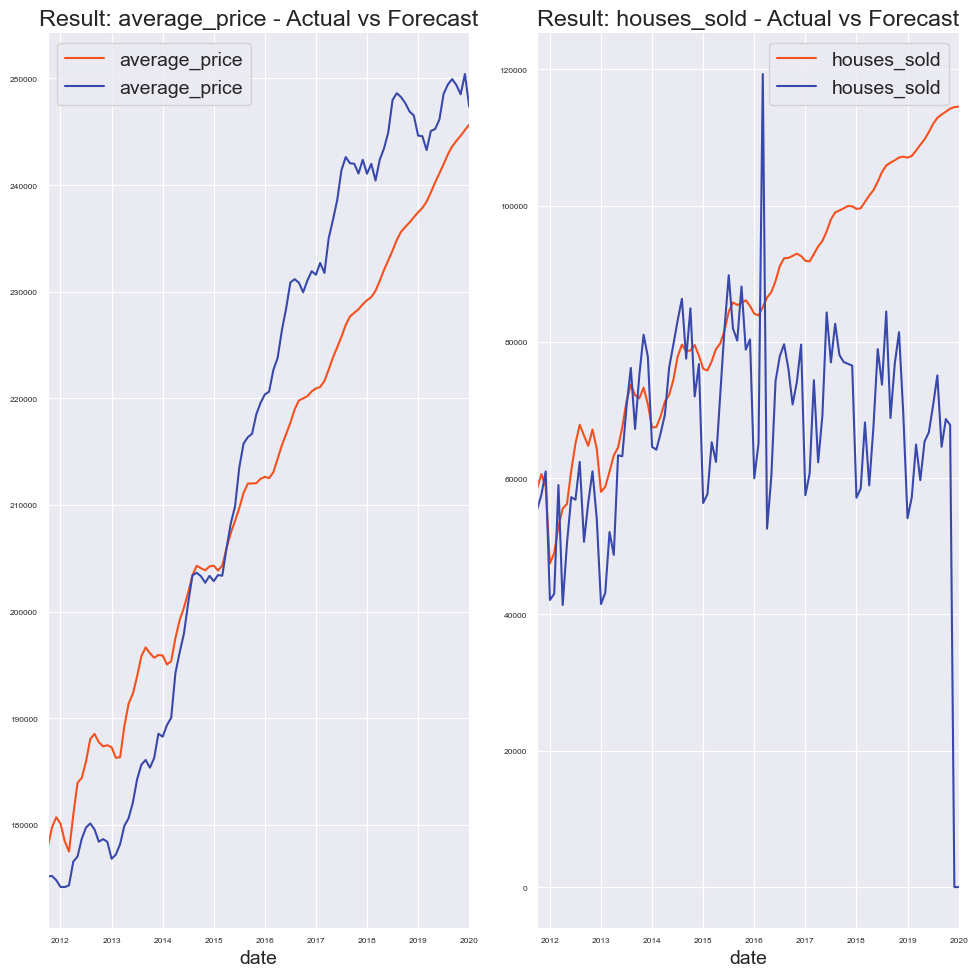

291204991.8563904


In [38]:
model = VAR(df_differenced)
results = model.fit(maxlags = 15, ic = 'aic')
results.summary()

# Forecasting for 100 steps ahead
lag_order = results.k_ar
predicted = results.forecast(df_differenced.values[-lag_order:], n_obs)
forecast = pd.DataFrame(predicted, index = df.index[-n_obs:], columns = df.columns)

# Plotting the Forecasted values
p1 = results.plot_forecast(1)
p1.tight_layout()

# Inverting the Differencing Transformation
def invert_transformation(df, df_forecast, second_diff=False):
    for col in df.columns:
        # Undo the 2nd Differencing
        if second_diff:
            df_forecast[str(col)] = (df[col].iloc[-1] - df[col].iloc[-2]) + df_forecast[str(col)].cumsum()

        # Undo the 1st Differencing
        df_forecast[str(col)] = df[col].iloc[-1] + df_forecast[str(col)].cumsum()

    return df_forecast

forecast_values = invert_transformation(df_train, forecast, second_diff=True)

# ======================================   Visualization  ==========================================
# Actual vs Forecasted Plots
fig, axes = plt.subplots(nrows = int(len(df.columns)/2), ncols = 2, dpi = 100, figsize = (10,10))

for i, (col, ax) in enumerate(zip(df.columns, axes.flatten())):
    forecast_values[col].plot(color = '#F4511E', legend = True, ax = ax).autoscale(axis =' x',tight = True)
    df_test[col].plot(color = '#3949AB', legend = True, ax = ax)

    ax.set_title('Result: ' + col + ' - Actual vs Forecast')
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize = 6)

plt.tight_layout()
plt.savefig('actual_forecast.png')
plt.show()

mse = mean_squared_error(df_test, forecast_values)
print(mse)

###### Analytics Vidhya

In [117]:
df.head()

average_price  houses_sold  no_of_crimes
date                                                
1995-01-01          91449        17.00          0.00
1995-02-01          82203         7.00          0.00
1995-03-01          79121        14.00          0.00
1995-04-01          77101         7.00          0.00
1995-05-01          84409        10.00          0.00

In [114]:
#creating the train and validation set
train = df[:int(0.8*(len(df)))]
valid = df[int(0.8*(len(df))):]

In [116]:
model = VAR(endog=df_train)
model_fit = model.fit()

# make prediction on validation
prediction = model_fit.forecast(model_fit.y, steps=len(df_test))

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [ ]:
#converting predictions to dataframe
pred = pd.DataFrame(index=range(0,len(prediction)),columns=[cols])
for j in range(0,13):
    for i in range(0, len(prediction)):
       pred.iloc[i][j] = prediction[i][j]

#check rmse
for i in cols:
    print('rmse value for', i, 'is : ', sqrt(mean_squared_error(pred[i], valid[i])))

In [ ]:
#make final predictions
model = VAR(endog=data)
model_fit = model.fit()
yhat = model_fit.forecast(model_fit.y, steps=1)
print(yhat)

###### TDS

https://towardsdatascience.com/multivariate-time-series-forecasting-653372b3db36

In [127]:
df.head()

average_price  houses_sold  no_of_crimes
date                                                
1995-01-01          91449        17.00          0.00
1995-02-01          82203         7.00          0.00
1995-03-01          79121        14.00          0.00
1995-04-01          77101         7.00          0.00
1995-05-01          84409        10.00          0.00

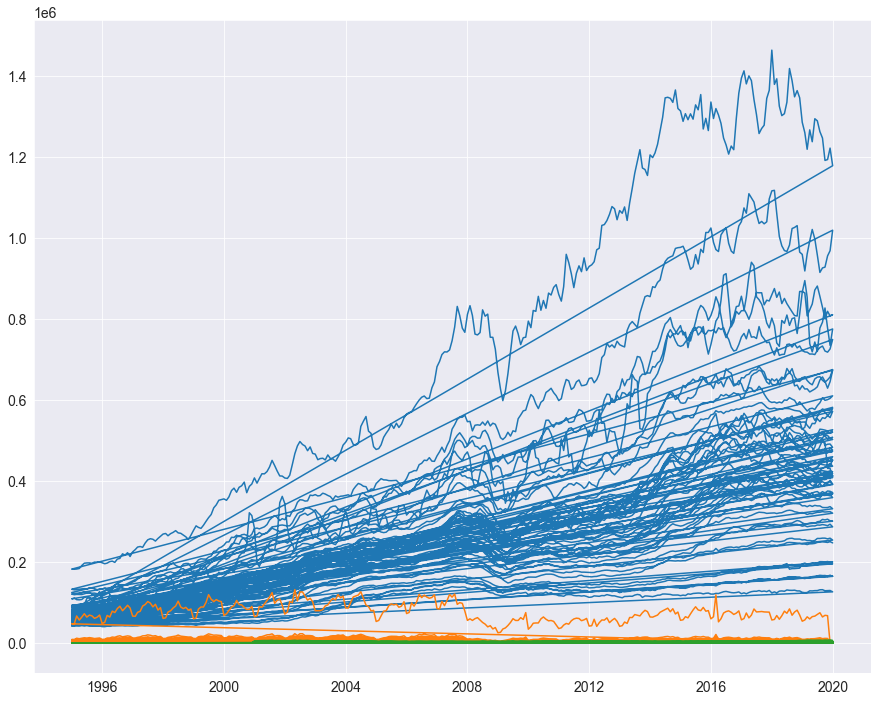

In [120]:
plt.plot(df)

In [125]:
# granger_test = sm.tsa.stattools.grangercausalitytests(df, maxlag=2, verbose=True)
# granger_test

In [121]:
nobs = 4
df_train, df_test = df[0:-nobs], df[-nobs:]

In [128]:
# Augmented Dickey-Fuller Test (ADF Test)/unit root test
from statsmodels.tsa.stattools import adfuller
def adf_test(ts, signif=0.05):
    dftest = adfuller(ts, autolag='AIC')
    adf = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags','# Observations'])
    for key,value in dftest[4].items():
       adf['Critical Value (%s)'%key] = value
    print (adf)
    
    p = adf['p-value']
    if p <= signif:
        print(f" Series is Stationary")
    else:
        print(f" Series is Non-Stationary")
#apply adf test on the series
adf_test(df_train["average_price"])
adf_test(df_train["houses_sold"])
adf_test(df_train["no_of_crimes"])

Test Statistic             -8.94
p-value                     0.00
# Lags                     13.00
# Observations         13,125.00
Critical Value (1%)        -3.43
Critical Value (5%)        -2.86
Critical Value (10%)       -2.57
dtype: float64
 Series is Stationary
Test Statistic             -1.30
p-value                     0.63
# Lags                     41.00
# Observations         13,097.00
Critical Value (1%)        -3.43
Critical Value (5%)        -2.86
Critical Value (10%)       -2.57
dtype: float64
 Series is Non-Stationary
Test Statistic             -8.94
p-value                     0.00
# Lags                     37.00
# Observations         13,101.00
Critical Value (1%)        -3.43
Critical Value (5%)        -2.86
Critical Value (10%)       -2.57
dtype: float64
 Series is Stationary


In [129]:
# 1st difference
df_differenced = df_train.diff().dropna()
# stationarity test again with differenced data
adf_test(df_differenced["houses_sold"])

Test Statistic            -19.37
p-value                     0.00
# Lags                     41.00
# Observations         13,096.00
Critical Value (1%)        -3.43
Critical Value (5%)        -2.86
Critical Value (10%)       -2.57
dtype: float64
 Series is Stationary


In [118]:
# model = VAR(df)
# model_fit = model.fit()

In [130]:
# model fitting
model = VAR(df_differenced)
results = model.fit(maxlags=15, ic='aic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 30, May, 2021
Time:                     00:52:41
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    45.9121
Nobs:                     13125.0    HQIC:                   45.8665
Log likelihood:          -356600.    FPE:                8.12189e+19
AIC:                      45.8437    Det(Omega_mle):     8.04808e+19
--------------------------------------------------------------------
Results for equation average_price
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                    -1.639070       232.290750           -0.007           0.994
L1.average_price          0.006512         0.009806            0.664           0.507
L1.houses_sold            0.188414  

In [132]:
# pred = model_fit.forecast(model_fit.y, steps=1)
# print(pred)

In [131]:
# forecasting
lag_order = results.k_ar
results.forecast(df.values[-lag_order:], 5)

array([[ 1.29491401e+05, -1.67057871e+04,  2.49214825e+02],
       [ 1.14041275e+05, -7.74011047e+03,  8.58045554e+01],
       [ 9.72801150e+04, -1.24553313e+03,  1.40352838e+02],
       [ 9.59349792e+04,  1.05451669e+03,  1.22123163e+02],
       [ 8.87814368e+04,  1.40091341e+04,  1.43133556e+02]])

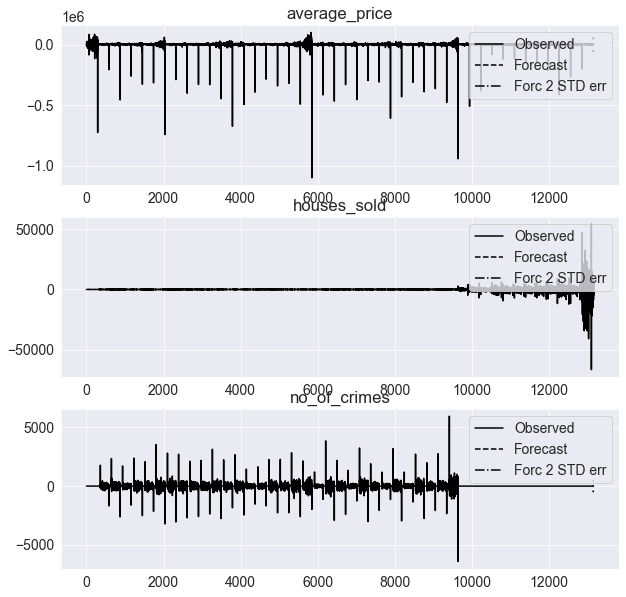

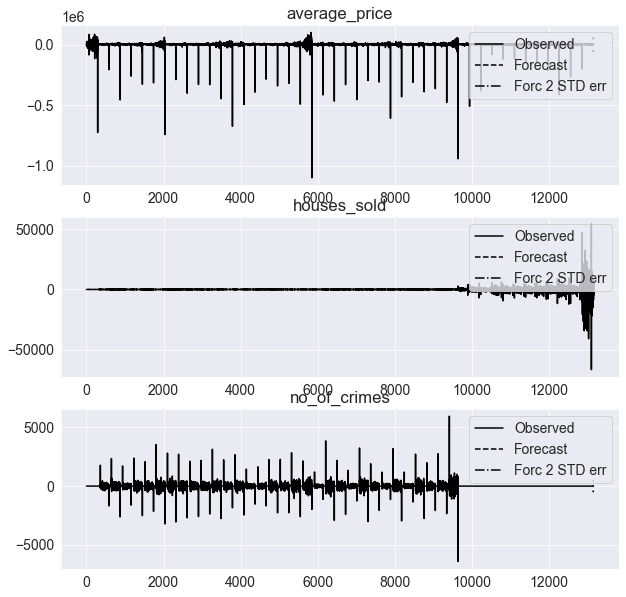

In [133]:
# plotting
results.plot_forecast(20)

In [134]:
# Evaluation
fevd = results.fevd(5)
fevd.summary()

FEVD for average_price
     average_price  houses_sold  no_of_crimes
0         1.000000     0.000000      0.000000
1         0.999821     0.000149      0.000030
2         0.998289     0.001135      0.000576
3         0.997658     0.001136      0.001206
4         0.996260     0.001149      0.002591

FEVD for houses_sold
     average_price  houses_sold  no_of_crimes
0         0.001401     0.998599      0.000000
1         0.001269     0.998691      0.000040
2         0.001439     0.998488      0.000073
3         0.001514     0.998397      0.000088
4         0.001521     0.998363      0.000116

FEVD for no_of_crimes
     average_price  houses_sold  no_of_crimes
0         0.204135     0.000168      0.795697
1         0.195720     0.000161      0.804119
2         0.194475     0.000169      0.805357
3         0.194239     0.000169      0.805592
4         0.194185     0.000169      0.805646




In [136]:
# forecasting
pred = results.forecast(results.y, steps=nobs)
df_forecast = pd.DataFrame(pred, index=df.index[-nobs:], columns=df.columns + '_1d')
df_forecast.tail()
# inverting transformation
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_1d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc
# show inverted results in a dataframe
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        
df_results.loc[:, ['average_price_forecast', 'houses_sold_forecast', 'no_of_crimes_forecast']]

average_price_forecast  houses_sold_forecast  \
date                                                       
2019-10-01              249,464.37             58,477.13   
2019-11-01              244,698.95             52,588.04   
2019-12-01              239,446.73             38,251.25   
2020-01-01              232,058.02             20,001.36   

            no_of_crimes_forecast  
date                               
2019-10-01                  -0.76  
2019-11-01                  -9.70  
2019-12-01                 -15.58  
2020-01-01                 -17.11

###### other references

https://www.kaggle.com/lokeshkumarn/timeseries-multivariate

https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

https://www.statsmodels.org/stable/vector_ar.html#vector-ar--page-root

https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.varmax.VARMAX.html